In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 6.0)

import numpy as np
import math
import seaborn as sns
from fbprophet import Prophet

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

In [2]:
from bokeh.plotting import output_file, show, figure
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [3]:
dataset = pd.read_csv('724940_all.csv')
dataset.head()

,YYYY-MM-DD,HH:MM (LST),Zenith (deg),Azimuth (deg),ETR (W/m^2),ETRN (W/m^2),Glo Mod (W/m^2),Glo Mod Unc (%),Glo Mod Source,Dir Mod (W/m^2),Dir Mod Unc (%),Dir Mod Source,Dif Mod (W/m^2),Dif Mod Unc (%),Dif Mod Source,Meas Glo (W/m^2),Meas Glo Flg,Meas Dir (W/m^2),Meas Dir Flg,Meas Dif (W/m^2),Meas Dif Flg,TotCC (10ths),Precip Wat (cm),Precip Wat Flg,AOD (unitless),AOD Flg
0,1991-01-01,1:00,99.00000,-99.00000,0,0,0,0,1,0,0,1,0,0,1,-9900,99,-9900,99,-9900,99,6,0.70000,1,0.10800,1
1,1991-01-01,2:00,99.00000,-99.00000,0,0,0,0,1,0,0,1,0,0,1,-9900,99,-9900,99,-9900,99,10,0.70000,1,0.10800,1
2,1991-01-01,3:00,99.00000,-99.00000,0,0,0,0,1,0,0,1,0,0,1,-9900,99,-9900,99,-9900,99,10,0.80000,1,0.10800,1
3,1991-01-01,4:00,99.00000,-99.00000,0,0,0,0,1,0,0,1,0,0,1,-9900,99,-9900,99,-9900,99,10,0.80000,1,0.10800,1
4,1991-01-01,5:00,99.00000,-99.00000,0,0,0,0,1,0,0,1,0,0,1,-9900,99,-9900,99,-9900,99,10,0.80000,1,0.10800,1


## Preprocess dataframe and select the features

In [4]:
# To preprocess the data frame and caculate the GHI
def preprocess(df):
    # Select columns
    df = df.loc[:, ['YYYY-MM-DD', 'HH:MM (LST)', 'Zenith (deg)', 'Dir Mod (W/m^2)', \
                    'Dif Mod  (W/m^2)', 'Meas Dir (W/m^2)', 'Meas Dif (W/m^2)',
                    'Precip Wat (cm)', 'AOD (unitless)']]
    
    # Convert degree to radian
    df['Zenith (deg)'] = df['Zenith (deg)'].apply(math.radians)
    df = df.rename({'Zenith (deg)': 'Zenith (rad)'}, axis = 1)
    
    # Calculate GHI
    df['GHI'] = df['Dif Mod  (W/m^2)'].astype('float') + \
                df['Dir Mod (W/m^2)']. astype('float') * df['Zenith (rad)'].apply(math.cos)

    return df

In [5]:
dataset_post = preprocess(dataset)
dataset_post.head()

,YYYY-MM-DD,HH:MM (LST),Zenith (rad),Dir Mod (W/m^2),Dif Mod (W/m^2),Meas Dir (W/m^2),Meas Dif (W/m^2),Precip Wat (cm),AOD (unitless),GHI
0,1991-01-01,1:00,1.72788,0,0,-9900,-9900,0.70000,0.10800,0.00000
1,1991-01-01,2:00,1.72788,0,0,-9900,-9900,0.70000,0.10800,0.00000
2,1991-01-01,3:00,1.72788,0,0,-9900,-9900,0.80000,0.10800,0.00000
3,1991-01-01,4:00,1.72788,0,0,-9900,-9900,0.80000,0.10800,0.00000
4,1991-01-01,5:00,1.72788,0,0,-9900,-9900,0.80000,0.10800,0.00000


In [6]:
dataset_post.tail()

,YYYY-MM-DD,HH:MM (LST),Zenith (rad),Dir Mod (W/m^2),Dif Mod (W/m^2),Meas Dir (W/m^2),Meas Dif (W/m^2),Precip Wat (cm),AOD (unitless),GHI
131491,2005-12-31,20:00,1.72788,0,0,-9900,-9900,2.00000,0.04900,0.00000
131492,2005-12-31,21:00,1.72788,0,0,-9900,-9900,2.00000,0.04900,0.00000
131493,2005-12-31,22:00,1.72788,0,0,-9900,-9900,2.00000,0.04900,0.00000
131494,2005-12-31,23:00,1.72788,0,0,-9900,-9900,2.00000,0.04900,0.00000
131495,2005-12-31,24:00,1.72788,0,0,-9900,-9900,2.00000,0.04900,0.00000


In [7]:
dataset_post['YYYY-MM-DD'] = pd.to_datetime(dataset_post['YYYY-MM-DD'])  
dataset_post = dataset_post.rename({'YYYY-MM-DD':'Datetime'}, axis = 1)
dataset_post.head()

,Datetime,HH:MM (LST),Zenith (rad),Dir Mod (W/m^2),Dif Mod (W/m^2),Meas Dir (W/m^2),Meas Dif (W/m^2),Precip Wat (cm),AOD (unitless),GHI
0,1991-01-01,1:00,1.72788,0,0,-9900,-9900,0.70000,0.10800,0.00000
1,1991-01-01,2:00,1.72788,0,0,-9900,-9900,0.70000,0.10800,0.00000
2,1991-01-01,3:00,1.72788,0,0,-9900,-9900,0.80000,0.10800,0.00000
3,1991-01-01,4:00,1.72788,0,0,-9900,-9900,0.80000,0.10800,0.00000
4,1991-01-01,5:00,1.72788,0,0,-9900,-9900,0.80000,0.10800,0.00000


In [8]:
daily = dataset_post.groupby('Datetime')
daily_data = daily['Datetime', 'GHI', 'Precip Wat (cm)', 'AOD (unitless)'].mean()

In [9]:
daily_data.head()

,GHI,Precip Wat (cm),AOD (unitless)
Datetime,,,
1991-01-01,95.99922,0.82500,0.10233
1991-01-02,79.88263,1.00000,0.10283
1991-01-03,66.10387,1.15417,0.09408
1991-01-04,104.28998,1.11250,0.08858
1991-01-05,92.72703,1.00000,0.13192


In [10]:
daily_data = daily_data.rename({'Precip Wat (cm)':'Precip_water', 'AOD (unitless)':'AOD'}, axis = 1)
daily_data.head()

,GHI,Precip_water,AOD
Datetime,,,
1991-01-01,95.99922,0.82500,0.10233
1991-01-02,79.88263,1.00000,0.10283
1991-01-03,66.10387,1.15417,0.09408
1991-01-04,104.28998,1.11250,0.08858
1991-01-05,92.72703,1.00000,0.13192


In [11]:
daily_ts = daily_data.astype('d')
daily_ts.index

DatetimeIndex(['1991-01-01', '1991-01-02', '1991-01-03', '1991-01-04',
               '1991-01-05', '1991-01-06', '1991-01-07', '1991-01-08',
               '1991-01-09', '1991-01-10',
               ...
               '2005-12-22', '2005-12-23', '2005-12-24', '2005-12-25',
               '2005-12-26', '2005-12-27', '2005-12-28', '2005-12-29',
               '2005-12-30', '2005-12-31'],
              dtype='datetime64[ns]', name=u'Datetime', length=5479, freq=None)

In [12]:
p = figure(width=800, height=350, x_axis_type="datetime")

# add renderers
p.line(daily_ts.index, daily_ts.GHI, color='navy', legend='GHI')
show(p)

## Facebook Prophet Model

In [13]:
ds = daily_ts.loc[:, ['GHI']]

In [14]:
ds.rename({'GHI':'y'}, axis = 1, inplace = True)

In [15]:
ds['ds'] = ds.index
ds.head()

,y,ds
Datetime,,
1991-01-01,95.99922,1991-01-01
1991-01-02,79.88263,1991-01-02
1991-01-03,66.10387,1991-01-03
1991-01-04,104.28998,1991-01-04
1991-01-05,92.72703,1991-01-05


In [16]:
ds = ds.reset_index()
ds.head()

,Datetime,y,ds
0,1991-01-01,95.99922,1991-01-01
1,1991-01-02,79.88263,1991-01-02
2,1991-01-03,66.10387,1991-01-03
3,1991-01-04,104.28998,1991-01-04
4,1991-01-05,92.72703,1991-01-05


In [17]:
ds.drop(columns=['Datetime'], inplace=True)
ds.head()

,y,ds
0,95.99922,1991-01-01
1,79.88263,1991-01-02
2,66.10387,1991-01-03
3,104.28998,1991-01-04
4,92.72703,1991-01-05


In [18]:
m = Prophet(daily_seasonality=True)
m.fit(ds)

/Users/qianyu/anaconda/envs/tensorflow/lib/python2.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [19]:
future = m.make_future_dataframe(periods = 365)
future.tail()

,ds
5839,2006-12-27
5840,2006-12-28
5841,2006-12-29
5842,2006-12-30
5843,2006-12-31


In [20]:
type(future)

pandas.core.frame.DataFrame

In [21]:
forecast = m.predict(future)
forecast.head()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,daily,daily_lower,daily_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,1991-01-01,115.15402,115.15402,115.15402,19.26727,142.95328,76.74196,76.74196,76.74196,-35.71147,-35.71147,-35.71147,-35.71147,-35.71147,-35.71147,0.27753,0.27753,0.27753,-112.73096,-112.73096,-112.73096,79.44255
1,1991-01-02,115.15593,115.15593,115.15593,11.79669,141.11527,76.74196,76.74196,76.74196,-37.30855,-37.30855,-37.30855,-37.30855,-37.30855,-37.30855,-1.26956,-1.26956,-1.26956,-112.78095,-112.78095,-112.78095,77.84738
2,1991-01-03,115.15785,115.15785,115.15785,13.53348,147.99520,76.74196,76.74196,76.74196,-38.49885,-38.49885,-38.49885,-38.49885,-38.49885,-38.49885,-2.50747,-2.50747,-2.50747,-112.73334,-112.73334,-112.73334,76.65900
3,1991-01-04,115.15977,115.15977,115.15977,11.77667,144.30722,76.74196,76.74196,76.74196,-36.27334,-36.27334,-36.27334,-36.27334,-36.27334,-36.27334,-0.43251,-0.43251,-0.43251,-112.58279,-112.58279,-112.58279,78.88642
4,1991-01-05,115.16168,115.16168,115.16168,16.78442,142.30891,76.74196,76.74196,76.74196,-35.94768,-35.94768,-35.94768,-35.94768,-35.94768,-35.94768,-0.36401,-0.36401,-0.36401,-112.32563,-112.32563,-112.32563,79.21400


In [32]:
forecast.tail()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,daily,daily_lower,daily_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
5839,2006-12-27,104.39502,103.76772,104.96816,2.33904,133.39395,76.74196,76.74196,76.74196,-35.82354,-35.82354,-35.82354,-35.82354,-35.82354,-35.82354,-1.26956,-1.26956,-1.26956,-111.29594,-111.29594,-111.29594,68.57148
5840,2006-12-28,104.39253,103.76409,104.96761,1.16265,131.39948,76.74196,76.74196,76.74196,-37.47487,-37.47487,-37.47487,-37.47487,-37.47487,-37.47487,-2.50747,-2.50747,-2.50747,-111.70936,-111.70936,-111.70936,66.91767
5841,2006-12-29,104.39004,103.76067,104.96855,7.70259,130.35952,76.74196,76.74196,76.74196,-35.76035,-35.76035,-35.76035,-35.76035,-35.76035,-35.76035,-0.43251,-0.43251,-0.43251,-112.06980,-112.06980,-112.06980,68.62969
5842,2006-12-30,104.38755,103.75373,104.96858,4.66218,131.77869,76.74196,76.74196,76.74196,-35.98878,-35.98878,-35.98878,-35.98878,-35.98878,-35.98878,-0.36401,-0.36401,-0.36401,-112.36673,-112.36673,-112.36673,68.39877
5843,2006-12-31,104.38507,103.74878,104.96835,4.98397,132.13725,76.74196,76.74196,76.74196,-33.53787,-33.53787,-33.53787,-33.53787,-33.53787,-33.53787,2.31035,2.31035,2.31035,-112.59018,-112.59018,-112.59018,70.84719


In [29]:
forecast.shape[0] - 365

5479

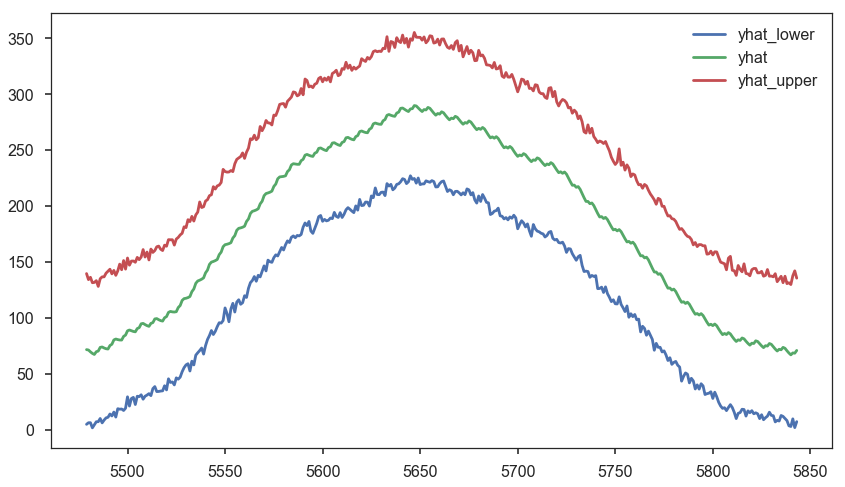

In [30]:
forecast.loc[5479:, ['yhat_lower', 'yhat', 'yhat_upper']].plot(figsize=(14, 8))

In [23]:
forecast.columns

Index([u'ds', u'trend', u'trend_lower', u'trend_upper', u'yhat_lower',
       u'yhat_upper', u'daily', u'daily_lower', u'daily_upper', u'seasonal',
       u'seasonal_lower', u'seasonal_upper', u'seasonalities',
       u'seasonalities_lower', u'seasonalities_upper', u'weekly',
       u'weekly_lower', u'weekly_upper', u'yearly', u'yearly_lower',
       u'yearly_upper', u'yhat'],
      dtype='object')

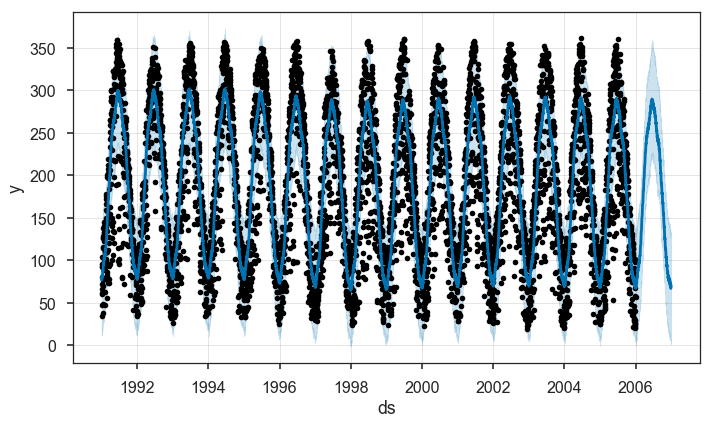

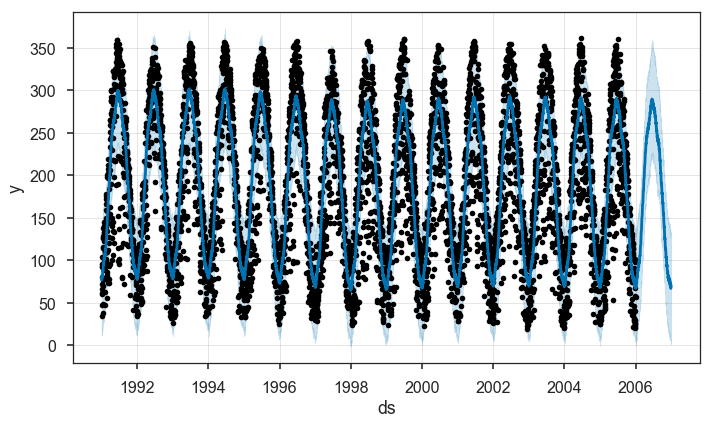

In [33]:
m.plot(forecast)

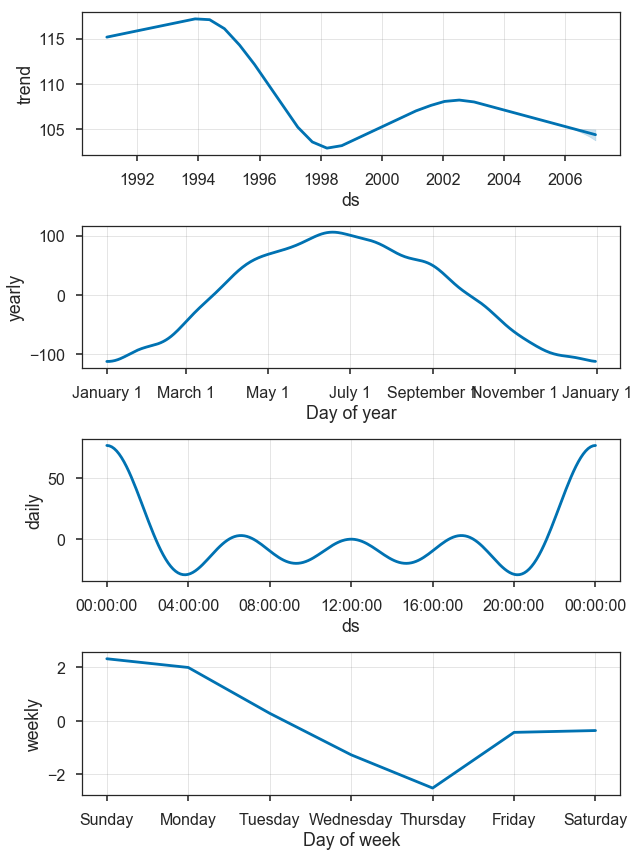

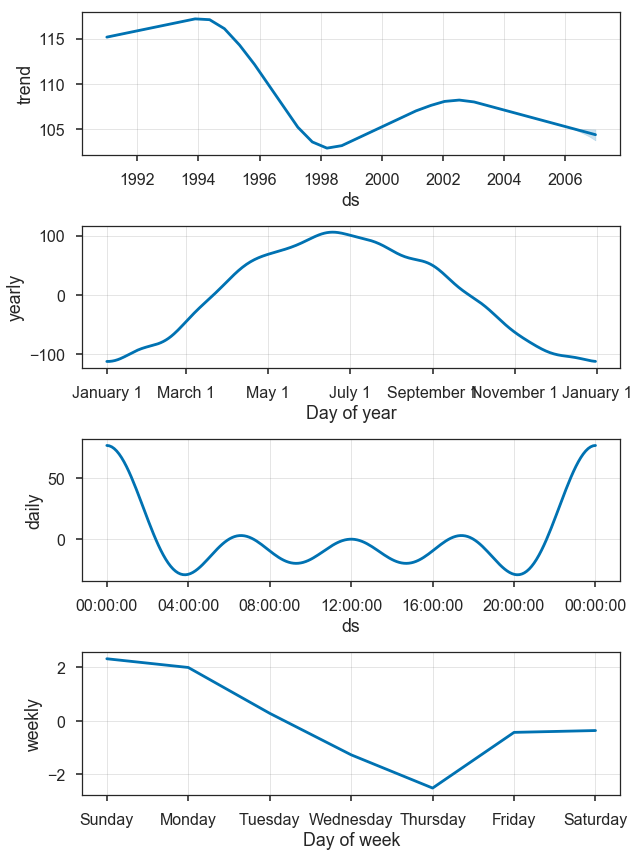

In [34]:
m.plot_components(forecast)